#### INTRODUCTION

The goal of this project is to wrangle WeRateDogs twitter archive data to uncover interesting insights through analysis and visualizations. Twitter archive contains only basic information about the tweets, challenge here is to gather gather additional information by querying tweet's API. Then the data will be assessed and cleaned for quality and tidiness issues. The master dataset will be subjected to extensive analysis to communicate critical findings. 

In [2]:
# Importing libraries
import pandas as pd
import requests
import os
import tweepy
from tweepy import OAuthHandler
import json
import timeit
import csv
import sys
import time
import datetime
import re

In [3]:
# Reading data through pandas and storing in tweet_data variable.
tweet_data= pd.read_csv('twitter-archive-enhanced.csv')
tweet_data.head()


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [6]:
# Details about tweet_data dataframe
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [7]:
# Programmatically downloading dog image prediction files
# from Udacity server using Request library
folder_name= 'twitter_image_predictions'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

url='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response= requests.get(url)

with open(os.path.join(folder_name, url.split('/')[-1]), mode='wb') as file:
    file.write(response.content)
    
# To check if our folder was created
os.listdir(folder_name)
    


['image-predictions.tsv']

In [8]:
# Open and store tsv file under images object
images=pd.read_csv("twitter_image_predictions/image-predictions.tsv", sep='\t')

#To identify the data types of objects and the structure of data frame images
images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


##### Query Twitter's API for each tweet's JSON data using Tweepy library and store each tweet's entire set of JSON data in a file


In [9]:
# Authentication for twitter's API

consumer_key='9SNtiAhQ5Fp3VOriUSvr7RuJ8'
consumer_secret='JYTbVHdmUB9gJQWiMfKyviUYgK9MD3THoZO8JXomsZlKKQIWLq'
access_token='2486984695-JSgkXytSxkPoaxcEBBz1ftpHPK3F62bv6VygRZO'
access_token_secret='0DDTJD14uQvXtSpbCP9gXcibZpI2eXoozHVP1x7C0WaO4'

auth= tweepy.OAuthHandler(consumer_key, consumer_secret)
api=tweepy.API(auth,
               wait_on_rate_limit=True,
               wait_on_rate_limit_notify=True)

In [10]:
# Extracting tweet data from tweet_id
# dictionary where data will be stored
df_list={}

# Calculating start time
start=timeit.timeit()
print(start)
for tweet in tweet_data['tweet_id']:
    try:
        info = api.get_status(tweet,
                              tweet_mode='extended')
        df_list[str(tweet)] = info._json
    except: 
        print("Error for: " + str(tweet))
        
# Caculating end time
end=timeit.timeit()
print (end)
   


0.010189546999981758
Error for: 888202515573088257
Error for: 873697596434513921
Error for: 869988702071779329
Error for: 866816280283807744
Error for: 861769973181624320
Error for: 842892208864923648
Error for: 827228250799742977
Error for: 802247111496568832
Error for: 775096608509886464
Rate limit reached. Sleeping for: 675
Rate limit reached. Sleeping for: 674
0.00854661000039414


In [11]:
# Import json file and create dataframe from list of dictionaries 
with open ('tweet_json.txt','w') as file:
    json.dump(df_list, file,
              sort_keys= True,
              indent=4)
    
json_df= pd.read_json('tweet_json.txt', orient='index')         


In [12]:
json_df
        

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
1991-02-08 13:48:08.022790149,NaN,NaN,2015-11-15 22:32:08,"[0, 131]","{'hashtags': [], 'media': [{'display_url': 'pi...",{'media': [{'display_url': 'pic.twitter.com/BL...,2529,0,Here we have a Japanese Irish Setter. Lost eye...,NaN,...,0.0,NaN,NaN,NaN,519,0,NaN,"<a href=""http://twitter.com/download/iphone"" r...",0,"{'contributors_enabled': False, 'created_at': ..."
1991-02-08 16:08:05.002620928,NaN,NaN,2015-11-15 23:05:30,"[0, 139]","{'hashtags': [], 'media': [{'display_url': 'pi...",{'media': [{'display_url': 'pic.twitter.com/r7...,130,0,This is a western brown Mitsubishi terrier. Up...,NaN,...,0.0,NaN,NaN,NaN,47,0,NaN,"<a href=""http://twitter.com/download/iphone"" r...",0,"{'contributors_enabled': False, 'created_at': ..."
1991-02-08 17:16:52.701032449,NaN,NaN,2015-11-15 23:21:54,"[0, 130]","{'hashtags': [], 'media': [{'display_url': 'pi...",{'media': [{'display_url': 'pic.twitter.com/y6...,126,0,Here is a very happy pup. Big fan of well-main...,NaN,...,0.0,NaN,NaN,NaN,46,0,NaN,"<a href=""http://twitter.com/download/iphone"" r...",0,"{'contributors_enabled': False, 'created_at': ..."
1991-02-08 20:17:06.329800704,NaN,NaN,2015-11-16 00:04:52,"[0, 137]","{'hashtags': [], 'media': [{'display_url': 'pi...",{'media': [{'display_url': 'pic.twitter.com/DW...,304,0,This is a purebred Piers Morgan. Loves to Netf...,NaN,...,0.0,NaN,NaN,NaN,143,0,NaN,"<a href=""http://twitter.com/download/iphone"" r...",0,"{'contributors_enabled': False, 'created_at': ..."
1991-02-08 21:40:48.165822465,NaN,NaN,2015-11-16 00:24:50,"[0, 120]","{'hashtags': [], 'media': [{'display_url': 'pi...",{'media': [{'display_url': 'pic.twitter.com/4B...,108,0,Here we have a 1949 1st generation vulpix. Enj...,NaN,...,0.0,NaN,NaN,NaN,40,0,NaN,"<a href=""http://twitter.com/download/iphone"" r...",0,"{'contributors_enabled': False, 'created_at': ..."
1991-02-08 22:05:58.794694657,NaN,NaN,2015-11-16 00:30:50,"[0, 140]","{'hashtags': [], 'media': [{'display_url': 'pi...",{'media': [{'display_url': 'pic.twitter.com/fv...,134,0,This is a truly beautiful English Wilson Staff...,NaN,...,0.0,NaN,NaN,NaN,59,0,NaN,"<a href=""http://twitter.com/download/iphone"" r...",0,"{'contributors_enabled': False, 'created_at': ..."
1991-02-08 22:24:13.826850816,NaN,NaN,2015-11-16 00:35:11,"[0, 138]","{'hashtags': [], 'media': [{'display_url': 'pi...",{'media': [{'display_url': 'pic.twitter.com/v5...,1240,0,This is an odd dog. Hard on the outside but lo...,NaN,...,0.0,NaN,NaN,NaN,866,0,NaN,"<a href=""http://twitter.com/download/iphone"" r...",0,"{'contributors_enabled': False, 'created_at': ..."
1991-02-08 23:25:25.042405380,NaN,NaN,2015-11-16 00:49:46,"[0, 140]","{'hashtags': [], 'media': [{'display_url': 'pi...",{'media': [{'display_url': 'pic.twitter.com/rd...,444,0,Here is a Siberian heavily armored polar bear ...,NaN,...,0.0,NaN,NaN,NaN,258,0,NaN,"<a href=""http://twitter.com/download/iphone"" r...",0,"{'contributors_enabled': False, 'created_at': ..."
1991-02-08 23:51:30.499244032,NaN,NaN,2015-11-16 00:55:59,"[0, 124]","{'hashtags': [], 'media': [{'display_url': 'pi...",{'media': [{'display_url': 'pic.twitter.com/yW...,302,0,My oh my. This is a rare blond Canadian terrie...,NaN,...,0.0,NaN,NaN,NaN,144,0,NaN,"<a href=""http://twitter.com/download/iphone"" r...",0,"{'contributors_enabled': False, 'created_at': ..."
1991-02-09 00:16:40.524156928,NaN,NaN,2015-11-16 01:01:59,"[0, 135]","{'hashtags': [], 'media': [{'display_url': 'pi...",{'media': [{'display_url': 'pic.twitter.com/pY...,114,0,Here is the Rand Paul of retrievers folks! He'...,NaN,...,0.0,NaN,NaN,NaN,58,0,NaN,"<a href=""http://twitter.com/download/iphone"" r...",0,"{'contributors_enabled': False, 'created_at': ..."


### ASSESSING 

#### After gathering data from various sources, the data is assessed visually and programatically to identify data quality and tidiness issuess.            
        
        



In [13]:
tweet_data

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [14]:
tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [15]:
tweet_data.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2113,670434127938719744,NaN,NaN,2015-11-28 02:48:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Hank and Sully. Hank is very proud of the...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670434127...,11,10,Hank,None,None,None,None
1849,675781562965868544,NaN,NaN,2015-12-12 20:57:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Buddah. He was Waldo for Hallowee...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675781562...,11,10,Buddah,None,None,None,None
1585,686947101016735744,NaN,NaN,2016-01-12 16:25:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jackson. He was specifically told not ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/686947101...,11,10,Jackson,None,None,None,None


In [16]:
tweet_data.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [17]:
tweet_data.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [18]:
tweet_data[tweet_data.rating_numerator==1776]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
979,749981277374128128,NaN,NaN,2016-07-04 15:00:45 +0000,"<a href=""https://about.twitter.com/products/tw...",This is Atticus. He's quite simply America af....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277...,1776,10,Atticus,None,None,None,None


In [19]:
tweet_data.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [20]:
tweet_data[tweet_data.tweet_id==883482846933004288]


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bella. She hopes her smile made you sm...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/883482846...,5,10,Bella,None,None,None,None


In [21]:
tweet_data[tweet_data.rating_denominator==0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None


In [22]:
tweet_data.name.value_counts()

None            745
a                55
Charlie          12
Lucy             11
Cooper           11
Oliver           11
Lola             10
Tucker           10
Penny            10
Winston           9
Bo                9
Sadie             8
the               8
Toby              7
Daisy             7
an                7
Buddy             7
Bailey            7
Scout             6
Leo               6
Oscar             6
Koda              6
Rusty             6
Milo              6
Jax               6
Stanley           6
Bella             6
Dave              6
Jack              6
Bentley           5
               ... 
Autumn            1
Olaf              1
Rover             1
Ralph             1
Ron               1
Claude            1
Baron             1
Julio             1
Pippin            1
Gin               1
Bertson           1
Berb              1
Deacon            1
Bronte            1
Dutch             1
Poppy             1
Ginger            1
Sunshine          1
Bradlay           1


### Quality issues
#### Tweet_data dataframe

1)Retweets data information

2)Rating numerator and denominator colmuns has outliers and incorrect values extracted.

3)Dog stages has multiple variables as columns

4)Rating numerator and denominator data type is integer

5)timestamp data type is object

6)tweet_id column datatype is integer

7)Date and time columns datatype is object

8)unncecessary columns for analysis

9)Source column is not human readable

10)Check duplicated values from all columns

In [23]:
images


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [24]:
images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [25]:
images.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [26]:
images.sample(5)


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1214,743253157753532416,https://pbs.twimg.com/media/ClCQzFUUYAA5vAu.jpg,1,malamute,0.442612,True,Siberian_husky,0.368137,True,Eskimo_dog,0.177822,True
1433,773547596996571136,https://pbs.twimg.com/media/Crwxb5yWgAAX5P_.jpg,1,Norwegian_elkhound,0.372202,True,Chesapeake_Bay_retriever,0.137187,True,malamute,0.071436,True
918,701601587219795968,https://pbs.twimg.com/media/CbyW7B0W8AIX8kX.jpg,1,Chihuahua,0.993661,True,Pembroke,0.001505,True,toy_terrier,0.000867,True
1176,737678689543020544,https://pbs.twimg.com/media/CjzC2oGWYAAyIfG.jpg,1,Pembroke,0.935307,True,Cardigan,0.049874,True,Chihuahua,0.011603,True
1195,740365076218183684,https://pbs.twimg.com/media/CkZOGhJWsAAHvPv.jpg,1,bow_tie,0.246313,False,Windsor_tie,0.172446,False,mushroom,0.137516,False


In [27]:
images.jpg_url.value_counts()

https://pbs.twimg.com/media/CkjMx99UoAM2B1a.jpg                                            2
https://pbs.twimg.com/media/CWyD2HGUYAQ1Xa7.jpg                                            2
https://pbs.twimg.com/media/CsVO7ljW8AAckRD.jpg                                            2
https://pbs.twimg.com/media/Cwx99rpW8AMk_Ie.jpg                                            2
https://pbs.twimg.com/media/CZhn-QAWwAASQan.jpg                                            2
https://pbs.twimg.com/media/CVuQ2LeUsAAIe3s.jpg                                            2
https://pbs.twimg.com/media/CVgdFjNWEAAxmbq.jpg                                            2
https://pbs.twimg.com/ext_tw_video_thumb/675354114423808004/pu/img/qL1R_nGLqa6lmkOx.jpg    2
https://pbs.twimg.com/media/Cp6db4-XYAAMmqL.jpg                                            2
https://pbs.twimg.com/media/CkNjahBXAAQ2kWo.jpg                                            2
https://pbs.twimg.com/media/CxqsX-8XUAAEvjD.jpg                       

### Images 

### Quality issues

1) p1 column starting letter of each word is not capitalized.

2) p2 column starting letter of each word is not capitalized.

3) p3 column starting letter of each word is not capitalized.

4) Missing observations ( 2075 instead of 2356 )

5) Remove '_' from p1,p2,p3 columns

In [28]:
json_df.sample(5)


,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
1991-05-21 01:48:08.185167872,NaN,NaN,2015-12-10 03:19:24,"[0, 47]","{'hashtags': [], 'media': [{'display_url': 'pi...",{'media': [{'display_url': 'pic.twitter.com/L1...,1164,0,ER... MER... GERD 13/10 https://t.co/L1puJISV1a,NaN,...,0.0,NaN,NaN,NaN,273,0,NaN,"<a href=""http://twitter.com/download/iphone"" r...",0,"{'contributors_enabled': False, 'created_at': ..."
1998-01-28 10:53:20.019947520,NaN,NaN,2017-07-14 22:10:11,"[0, 140]","{'hashtags': [], 'media': [{'display_url': 'pi...",{'media': [{'display_url': 'pic.twitter.com/Bu...,33011,0,Viewer discretion advised. This is Jimbo. He w...,NaN,...,0.0,NaN,NaN,NaN,6942,0,NaN,"<a href=""http://twitter.com/download/iphone"" r...",0,"{'contributors_enabled': False, 'created_at': ..."
1991-09-22 09:38:12.383666176,NaN,NaN,2016-01-08 18:43:29,"[0, 132]","{'hashtags': [], 'media': [{'display_url': 'pi...",{'media': [{'display_url': 'pic.twitter.com/Gb...,3288,0,"For the last time, WE. DO. NOT. RATE. BULBASAU...",NaN,...,0.0,NaN,NaN,NaN,1283,0,NaN,"<a href=""http://twitter.com/download/iphone"" r...",0,"{'contributors_enabled': False, 'created_at': ..."
1992-12-11 03:59:03.203856385,NaN,NaN,2016-04-24 01:24:35,"[0, 98]","{'hashtags': [], 'media': [{'display_url': 'pi...",{'media': [{'display_url': 'pic.twitter.com/pI...,2860,0,This is Sarge. Not even he knows what his tong...,NaN,...,0.0,NaN,NaN,NaN,610,0,NaN,"<a href=""http://twitter.com/download/iphone"" r...",0,"{'contributors_enabled': False, 'created_at': ..."
1991-09-14 20:36:59.965411328,NaN,NaN,2016-01-06 23:33:58,"[0, 139]","{'hashtags': [], 'media': [{'display_url': 'pi...",{'media': [{'display_url': 'pic.twitter.com/Dn...,2270,0,Here we have a basking dino pupper. Looks powe...,NaN,...,0.0,NaN,NaN,NaN,922,0,NaN,"<a href=""http://twitter.com/download/iphone"" r...",0,"{'contributors_enabled': False, 'created_at': ..."


In [30]:
json_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2347 entries, 1991-02-08 13:48:08.022790149 to 1998-04-12 22:37:23.555336193
Data columns (total 31 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2347 non-null datetime64[ns]
display_text_range               2347 non-null object
entities                         2347 non-null object
extended_entities                2070 non-null object
favorite_count                   2347 non-null int64
favorited                        2347 non-null int64
full_text                        2347 non-null object
geo                              0 non-null float64
id                               2347 non-null int64
id_str                           2347 non-null int64
in_reply_to_screen_name          77 non-null object
in_reply_to_status_id            77 non-null float64
in_reply_to_status_id_str        77 non-null float64
in_reply_to_user_id              

In [31]:
json_df.describe()

,contributors,coordinates,favorite_count,favorited,geo,id,id_str,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,possibly_sensitive,possibly_sensitive_appealable,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,truncated
count,0.0,0.0,2347.000000,2347.0,0.0,2.347000e+03,2.347000e+03,7.700000e+01,7.700000e+01,7.700000e+01,7.700000e+01,2347.000000,2208.0,2208.0,2.800000e+01,2.800000e+01,2347.000000,2347.0,2347.0
mean,NaN,NaN,8117.439710,0.0,NaN,7.423783e+17,7.423783e+17,7.440692e+17,7.440692e+17,2.040329e+16,2.040329e+16,0.013208,0.0,0.0,8.214171e+17,8.214171e+17,3065.019173,0.0,0.0
std,NaN,NaN,12203.322117,0.0,NaN,6.836841e+16,6.836841e+16,7.524295e+16,7.524295e+16,1.260797e+17,1.260797e+17,0.114190,0.0,0.0,5.606440e+16,5.606440e+16,5090.020319,0.0,0.0
min,NaN,NaN,0.000000,0.0,NaN,6.660209e+17,6.660209e+17,6.658147e+17,6.658147e+17,1.185634e+07,1.185634e+07,0.000000,0.0,0.0,7.061659e+17,7.061659e+17,0.000000,0.0,0.0
25%,NaN,NaN,1409.000000,0.0,NaN,6.783846e+17,6.783846e+17,6.757073e+17,6.757073e+17,3.589728e+08,3.589728e+08,0.000000,0.0,0.0,7.942973e+17,7.942973e+17,611.500000,0.0,0.0
50%,NaN,NaN,3568.000000,0.0,NaN,7.189719e+17,7.189719e+17,7.032559e+17,7.032559e+17,4.196984e+09,4.196984e+09,0.000000,0.0,0.0,8.365177e+17,8.365177e+17,1434.000000,0.0,0.0
75%,NaN,NaN,10052.500000,0.0,NaN,7.987038e+17,7.987038e+17,8.233264e+17,8.233264e+17,4.196984e+09,4.196984e+09,0.000000,0.0,0.0,8.676130e+17,8.676130e+17,3575.000000,0.0,0.0
max,NaN,NaN,144129.000000,0.0,NaN,8.924206e+17,8.924206e+17,8.862664e+17,8.862664e+17,8.405479e+17,8.405479e+17,1.000000,0.0,0.0,8.860534e+17,8.860534e+17,78216.000000,0.0,0.0


In [32]:
json_df.id.value_counts()

685532292383666176    1
777621514455814144    1
768473857036525568    1
750071704093859840    1
751937170840121344    1
814530161257443328    1
700890391244103680    1
667177989038297088    1
827653905312006144    1
680055455951884288    1
762316489655476224    1
770655142660169728    1
680934982542561280    1
674742531037511680    1
838201503651401728    1
670093938074779648    1
759923798737051648    1
680161097740095488    1
891689557279858688    1
679527802031484928    1
783085703974514688    1
740995100998766592    1
698703483621523456    1
675798442703122432    1
669359674819481600    1
683834909291606016    1
668480044826800128    1
668268907921326080    1
710833117892898816    1
677557565589463040    1
                     ..
882045870035918848    1
720775346191278080    1
879492040517615616    1
775733305207554048    1
847157206088847360    1
834209720923721728    1
825026590719483904    1
776113305656188928    1
690938899477221376    1
678800283649069056    1
6780233232473579

### Json data

#### Quality

1) id data contains date and time created information
2) id name is unique and does not match with previous tweet_id column



### Tidiness Issues
#### Tweet_data dataframe

1)Date and time variables clubbed into single column

2)Mutliple dog stage columns

3)Unneceassary columns for analysis


## Cleaning


In [74]:
# Creating a copy of each dataframe to retain original files
tweet_data_clean=tweet_data.copy()
images_clean=images.copy()
json_df_clean=json_df.copy()

### Define

Checking for retweet records in the data

### Clean

In [34]:
tweet_data_clean[tweet_data_clean.retweeted_status_id.notnull()==True]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Terrance. He's being yelle...,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397...,11,10,Terrance,None,None,None,None
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @rachel2195: @dog_rates the boyfriend and h...,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,https://twitter.com/rachel2195/status/87685077...,14,10,None,None,None,pupper,None
91,874434818259525634,NaN,NaN,2017-06-13 01:14:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Coco. At first I though...,8.663350e+17,4.196984e+09,2017-05-21 16:48:45 +0000,https://twitter.com/dog_rates/status/866334964...,12,10,Coco,None,None,None,None
95,873697596434513921,NaN,NaN,2017-06-11 00:25:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Walter. He won't start ...,8.688804e+17,4.196984e+09,2017-05-28 17:23:24 +0000,https://twitter.com/dog_rates/status/868880397...,14,10,Walter,None,None,None,None
97,873337748698140672,NaN,NaN,2017-06-10 00:35:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Sierra. She's one preci...,8.732138e+17,4.196984e+09,2017-06-09 16:22:42 +0000,https://www.gofundme.com/help-my-baby-sierra-g...,12,10,Sierra,None,None,pupper,None


In [35]:
# Remove the retweet information from tweet_data dataframe
tweet_data_clean.drop(tweet_data_clean[tweet_data_clean['retweeted_status_id'].notnull()==True].index, inplace=True)



### Test

In [36]:
tweet_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

### Clean

In [75]:
# Deleting columns related to retweet data
tweet_data_clean=tweet_data_clean.drop('retweeted_status_id', 1)
tweet_data_clean=tweet_data_clean.drop('retweeted_status_user_id', 1)
tweet_data_clean=tweet_data_clean.drop('retweeted_status_timestamp', 1)



### Test

In [38]:
# Verifying the columns retained in tweet_data_clean dataframe
tweet_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null object
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     2175 non-null object
doggo                    2175 non-null object
floofer                  2175 non-null object
pupper                   2175 non-null object
puppo                    2175 non-null object
dtypes: float64(2), int64(3), object(9)
memory usage: 254.9+ KB


### Define

 Melt 'doggo', 'floofer', 'pupper', 'puppo' columns into  a single dog_stage column

### Clean

In [76]:
# Variables to melt
variables_melt= ['doggo', 'floofer', 'pupper', 'puppo']
variables_retain=[x for x in tweet_data_clean.columns.tolist() if x not in variables_melt]
tweet_data_clean=pd.melt(tweet_data_clean, id_vars= variables_retain,
                          value_vars= variables_melt ,var_name='stages',value_name='dog_stages')

### Test

In [41]:
tweet_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8700 entries, 0 to 8699
Data columns (total 12 columns):
tweet_id                 8700 non-null int64
in_reply_to_status_id    312 non-null float64
in_reply_to_user_id      312 non-null float64
timestamp                8700 non-null object
source                   8700 non-null object
text                     8700 non-null object
expanded_urls            8468 non-null object
rating_numerator         8700 non-null int64
rating_denominator       8700 non-null int64
name                     8700 non-null object
stages                   8700 non-null object
dog_stages               8700 non-null object
dtypes: float64(2), int64(3), object(7)
memory usage: 815.7+ KB


In [42]:
tweet_data_clean.stages.value_counts()

floofer    2175
puppo      2175
pupper     2175
doggo      2175
Name: stages, dtype: int64

In [77]:
# Delete stages column
tweet_data_clean=tweet_data_clean.drop('stages',1)


In [78]:
# Inspect and Remove duplicated rows based on dog_stage values
tweet_data_clean.dog_stages.value_counts()

tweet_data_clean=tweet_data_clean.sort_values('dog_stages').drop_duplicates('tweet_id', keep='last')

# Values of dog_stages after removing duplicates

print(tweet_data_clean.dog_stages.value_counts())


None       1976
pupper      257
doggo        83
puppo        30
floofer      10
Name: dog_stages, dtype: int64


### Define

Extracting correct values for rating numerator and denominator

### Clean

In [79]:
# Extracting ratings from tweet text and storing it in ratings variable
ratings=tweet_data_clean['text'].str.findall(r'(\d+(\.\d+)|(\d+))\/(\d+)')


In [80]:
# Check ratings datatype
type(ratings.iloc[0])

list

In [81]:
# Converting rating numerator datatype to float
tweet_data_clean.rating_numerator=tweet_data_clean.rating_numerator.astype(float)

In [82]:
#Verify the change in ratings value before and after extraction
print(tweet_data_clean[tweet_data_clean.tweet_id== 883482846933004288].rating_numerator)

for i, row in tweet_data_clean.iterrows():
    tweet_data_clean.set_value(i,'rating_numerator', float((ratings[i][-1][0])))
    tweet_data_clean.set_value(i,'rating_denominator', float((ratings[i][-1][3])))
        
print(tweet_data_clean[tweet_data_clean.tweet_id== 883482846933004288].rating_numerator)

45    5.0
Name: rating_numerator, dtype: float64
45    13.5
Name: rating_numerator, dtype: float64


### Test

In [83]:
tweet_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 2259 to 7236
Data columns (total 11 columns):
tweet_id                 2356 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2356 non-null object
source                   2356 non-null object
text                     2356 non-null object
expanded_urls            2297 non-null object
rating_numerator         2356 non-null float64
rating_denominator       2356 non-null int64
name                     2356 non-null object
dog_stages               2356 non-null object
dtypes: float64(3), int64(2), object(6)
memory usage: 300.9+ KB


### Define

1)Convert timestamp column from string to datetime object

2)Split timestamp column into time and date columns respectively

### Code

In [84]:
from datetime import timedelta

tweet_data_clean.timestamp= pd.to_datetime(tweet_data_clean.timestamp)

# Extract date and time information from timestamp column.
tweet_data_clean['date']= tweet_data_clean.timestamp.apply(lambda time: time.strftime('%m-%d-%Y'))
tweet_data_clean['time']= tweet_data_clean.timestamp.apply(lambda time: time.strftime('%H:%M'))

# Verify and delete timestamp column
tweet_data_clean=tweet_data_clean.drop('timestamp',1)


### Test

In [85]:
tweet_data_clean.sample(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stages,date,time
4307,673686845050527744,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is George. He's upset that the 4th of Jul...,https://twitter.com/dog_rates/status/673686845...,11.0,10,George,None,12-07-2015,02:13
2683,833732339549220864,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",RT @rolltidered: This is Gabby. Now requests t...,https://twitter.com/rolltidered/status/8324343...,12.0,10,Gabby,None,02-20-2017,17:37
4405,671504605491109889,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Charlie. He was just informed that dog...,https://twitter.com/dog_rates/status/671504605...,11.0,10,Charlie,None,12-01-2015,01:42


### Define

1) Convert tweet_id to objects

2) Convert date and time columns to datetime objects to ease calculations 

3) Convert rating numerator and denominator to float( assumption that ratings can be with decimal points too)

### Code


In [86]:
# Convert tweet_id to pandas object 
tweet_data_clean.tweet_id=tweet_data_clean.tweet_id.astype('str')


In [87]:
#Converting date and time columns to datetime objects

tweet_data_clean['date']= pd.to_datetime(tweet_data_clean['date'])
tweet_data_clean['time']= pd.to_datetime(tweet_data_clean['time'])


In [88]:
# Converting numerator and denominator ratings to float type
tweet_data_clean.rating_denominator=tweet_data_clean.rating_denominator.astype(float)
tweet_data_clean.rating_numerator=tweet_data_clean.rating_numerator.astype(float)

### Test

In [89]:
tweet_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 2259 to 7236
Data columns (total 12 columns):
tweet_id                 2356 non-null object
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
source                   2356 non-null object
text                     2356 non-null object
expanded_urls            2297 non-null object
rating_numerator         2356 non-null float64
rating_denominator       2356 non-null float64
name                     2356 non-null object
dog_stages               2356 non-null object
date                     2356 non-null datetime64[ns]
time                     2356 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(4), object(6)
memory usage: 319.3+ KB


### Define

#### Removing unwanted columns from tweet_data dataframe for efficient analysis

### Clean

In [90]:
tweet_data_clean.drop(['expanded_urls','text','in_reply_to_user_id', 'in_reply_to_status_id'], 1, inplace=True)

In [91]:
tweet_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 2259 to 7236
Data columns (total 8 columns):
tweet_id              2356 non-null object
source                2356 non-null object
rating_numerator      2356 non-null float64
rating_denominator    2356 non-null float64
name                  2356 non-null object
dog_stages            2356 non-null object
date                  2356 non-null datetime64[ns]
time                  2356 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 245.7+ KB


### Define


Clean the content of source column to make it easier to read

### Clean

In [92]:
tweet_data_clean.source=tweet_data_clean.source.apply(lambda x: re.findall(r'>(.*)<', x)[0])

  ### Test

In [93]:
tweet_data_clean.sample(2)

,tweet_id,source,rating_numerator,rating_denominator,name,dog_stages,date,time
4114,678755239630127104,Twitter for iPhone,10.0,10.0,Dash,None,2015-12-21,2018-02-16 01:53:00
2226,668274247790391296,Twitter for iPhone,10.0,10.0,Sophie,None,2015-11-22,2018-02-16 03:46:00


### Define

Get unique elements from all the columns

In [94]:
tweet_data_clean.apply(lambda x: len(x.unique()))

tweet_id              2356
source                   4
rating_numerator        39
rating_denominator      15
name                   957
dog_stages               5
date                   608
time                   775
dtype: int64

In [95]:
tweet_data_clean.source.value_counts()

Twitter for iPhone     2221
Vine - Make a Scene      91
Twitter Web Client       33
TweetDeck                11
Name: source, dtype: int64

### Images Dataframe

### Define

Remove '_' from p1, p2 , p3 columns 

### Code

In [96]:
images_clean['p1']=images_clean.p1.str.replace("_" , " " )
images_clean['p2']=images_clean.p2.str.replace('_', ' ')
images_clean['p3']=images_clean.p3.str.replace('_', ' ')

### Test

In [97]:
images_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh springer spaniel,0.465074,True,collie,0.156665,True,Shetland sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature pinscher,0.074192,True,Rhodesian ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian ridgeback,0.408143,True,redbone,0.360687,True,miniature pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Define

Capitalize the starting letter of first word in p1, p2 and p3 columns

### Code

In [98]:
images_clean.p1=images_clean.p1.str.capitalize()
images_clean.p2=images_clean.p2.str.capitalize()
images_clean.p3=images_clean.p3.str.capitalize()


### Test

In [99]:
images_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh springer spaniel,0.465074,True,Collie,0.156665,True,Shetland sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature pinscher,0.074192,True,Rhodesian ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian ridgeback,0.408143,True,Redbone,0.360687,True,Miniature pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Define

Convert tweet_id from integer to object datatype

### Clean

In [100]:
images_clean.tweet_id=images_clean.tweet_id.astype(str)

### Test

In [101]:
type(images_clean.tweet_id.iloc[0])

str

In [102]:
images_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


### json_df DataFrame

### Define

Convert id column to tweet_id column to match the other two columns id

### Clean

In [103]:
json_df_clean.rename(columns= {'id': 'tweet_id'}, inplace=True)

 ### Test

In [104]:
json_df_clean.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2347 entries, 1991-02-08 13:48:08.022790149 to 1998-04-12 22:37:23.555336193
Data columns (total 31 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2347 non-null datetime64[ns]
display_text_range               2347 non-null object
entities                         2347 non-null object
extended_entities                2070 non-null object
favorite_count                   2347 non-null int64
favorited                        2347 non-null int64
full_text                        2347 non-null object
geo                              0 non-null float64
tweet_id                         2347 non-null int64
id_str                           2347 non-null int64
in_reply_to_screen_name          77 non-null object
in_reply_to_status_id            77 non-null float64
in_reply_to_status_id_str        77 non-null float64
in_reply_to_user_id              

In [105]:
json_df_clean

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
1991-02-08 13:48:08.022790149,NaN,NaN,2015-11-15 22:32:08,"[0, 131]","{'hashtags': [], 'media': [{'display_url': 'pi...",{'media': [{'display_url': 'pic.twitter.com/BL...,2529,0,Here we have a Japanese Irish Setter. Lost eye...,NaN,...,0.0,NaN,NaN,NaN,519,0,NaN,"<a href=""http://twitter.com/download/iphone"" r...",0,"{'contributors_enabled': False, 'created_at': ..."
1991-02-08 16:08:05.002620928,NaN,NaN,2015-11-15 23:05:30,"[0, 139]","{'hashtags': [], 'media': [{'display_url': 'pi...",{'media': [{'display_url': 'pic.twitter.com/r7...,130,0,This is a western brown Mitsubishi terrier. Up...,NaN,...,0.0,NaN,NaN,NaN,47,0,NaN,"<a href=""http://twitter.com/download/iphone"" r...",0,"{'contributors_enabled': False, 'created_at': ..."
1991-02-08 17:16:52.701032449,NaN,NaN,2015-11-15 23:21:54,"[0, 130]","{'hashtags': [], 'media': [{'display_url': 'pi...",{'media': [{'display_url': 'pic.twitter.com/y6...,126,0,Here is a very happy pup. Big fan of well-main...,NaN,...,0.0,NaN,NaN,NaN,46,0,NaN,"<a href=""http://twitter.com/download/iphone"" r...",0,"{'contributors_enabled': False, 'created_at': ..."
1991-02-08 20:17:06.329800704,NaN,NaN,2015-11-16 00:04:52,"[0, 137]","{'hashtags': [], 'media': [{'display_url': 'pi...",{'media': [{'display_url': 'pic.twitter.com/DW...,304,0,This is a purebred Piers Morgan. Loves to Netf...,NaN,...,0.0,NaN,NaN,NaN,143,0,NaN,"<a href=""http://twitter.com/download/iphone"" r...",0,"{'contributors_enabled': False, 'created_at': ..."
1991-02-08 21:40:48.165822465,NaN,NaN,2015-11-16 00:24:50,"[0, 120]","{'hashtags': [], 'media': [{'display_url': 'pi...",{'media': [{'display_url': 'pic.twitter.com/4B...,108,0,Here we have a 1949 1st generation vulpix. Enj...,NaN,...,0.0,NaN,NaN,NaN,40,0,NaN,"<a href=""http://twitter.com/download/iphone"" r...",0,"{'contributors_enabled': False, 'created_at': ..."
1991-02-08 22:05:58.794694657,NaN,NaN,2015-11-16 00:30:50,"[0, 140]","{'hashtags': [], 'media': [{'display_url': 'pi...",{'media': [{'display_url': 'pic.twitter.com/fv...,134,0,This is a truly beautiful English Wilson Staff...,NaN,...,0.0,NaN,NaN,NaN,59,0,NaN,"<a href=""http://twitter.com/download/iphone"" r...",0,"{'contributors_enabled': False, 'created_at': ..."
1991-02-08 22:24:13.826850816,NaN,NaN,2015-11-16 00:35:11,"[0, 138]","{'hashtags': [], 'media': [{'display_url': 'pi...",{'media': [{'display_url': 'pic.twitter.com/v5...,1240,0,This is an odd dog. Hard on the outside but lo...,NaN,...,0.0,NaN,NaN,NaN,866,0,NaN,"<a href=""http://twitter.com/download/iphone"" r...",0,"{'contributors_enabled': False, 'created_at': ..."
1991-02-08 23:25:25.042405380,NaN,NaN,2015-11-16 00:49:46,"[0, 140]","{'hashtags': [], 'media': [{'display_url': 'pi...",{'media': [{'display_url': 'pic.twitter.com/rd...,444,0,Here is a Siberian heavily armored polar bear ...,NaN,...,0.0,NaN,NaN,NaN,258,0,NaN,"<a href=""http://twitter.com/download/iphone"" r...",0,"{'contributors_enabled': False, 'created_at': ..."
1991-02-08 23:51:30.499244032,NaN,NaN,2015-11-16 00:55:59,"[0, 124]","{'hashtags': [], 'media': [{'display_url': 'pi...",{'media': [{'display_url': 'pic.twitter.com/yW...,302,0,My oh my. This is a rare blond Canadian terrie...,NaN,...,0.0,NaN,NaN,NaN,144,0,NaN,"<a href=""http://twitter.com/download/iphone"" r...",0,"{'contributors_enabled': False, 'created_at': ..."
1991-02-09 00:16:40.524156928,NaN,NaN,2015-11-16 01:01:59,"[0, 135]","{'hashtags': [], 'media': [{'display_url': 'pi...",{'media': [{'display_url': 'pic.twitter.com/pY...,114,0,Here is the Rand Paul of retrievers folks! He'...,NaN,...,0.0,NaN,NaN,NaN,58,0,NaN,"<a href=""http://twitter.com/download/iphone"" r...",0,"{'contributors_enabled': False, 'created_at': ..."


### Define

Converting tweet_id datatype to object

### Clean

In [106]:
json_df_clean.tweet_id=json_df_clean.tweet_id.astype(str)

### Test

In [107]:
type(json_df_clean.tweet_id.iloc[0])

str

### Define

Removing data that are retweets because we only need original tweets for analysis

### Clean

In [108]:
json_df_clean[json_df_clean.retweeted_status.notnull()]

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,possibly_sensitive_appealable,quoted_status,quoted_status_id,quoted_status_id_str,retweet_count,retweeted,retweeted_status,source,truncated,user
1991-02-26 06:48:02.905632768,NaN,NaN,2015-11-20 03:51:47,"[0, 104]","{'hashtags': [], 'media': [{'display_url': 'pi...",{'media': [{'display_url': 'pic.twitter.com/r7...,0,0,RT @dogratingrating: Unoriginal idea. Blatant ...,NaN,...,0.0,NaN,NaN,NaN,34,0,"{'contributors': None, 'coordinates': None, 'c...","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",0,"{'contributors_enabled': False, 'created_at': ..."
1991-02-26 06:48:24.950915073,NaN,NaN,2015-11-20 03:51:52,"[0, 123]","{'hashtags': [], 'media': [{'display_url': 'pi...",{'media': [{'display_url': 'pic.twitter.com/ua...,0,0,RT @dogratingrating: Exceptional talent. Origi...,NaN,...,0.0,NaN,NaN,NaN,37,0,"{'contributors': None, 'coordinates': None, 'c...","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",0,"{'contributors_enabled': False, 'created_at': ..."
1992-07-24 17:26:49.858043904,NaN,NaN,2016-03-21 19:31:59,"[0, 97]","{'hashtags': [{'indices': [61, 73], 'text': 'L...",{'media': [{'display_url': 'pic.twitter.com/j6...,0,0,RT @twitter: @dog_rates Awesome Tweet! 12/10. ...,NaN,...,0.0,NaN,NaN,NaN,137,0,"{'contributors': None, 'coordinates': None, 'c...","<a href=""http://twitter.com/download/iphone"" r...",0,"{'contributors_enabled': False, 'created_at': ..."
1993-07-28 05:05:15.802583040,NaN,NaN,2016-06-17 16:01:16,"[0, 140]","{'hashtags': [], 'symbols': [], 'urls': [], 'u...",NaN,0,0,RT @dog_rates: Extremely intelligent dog here....,NaN,...,NaN,NaN,NaN,NaN,2341,0,"{'contributors': None, 'coordinates': None, 'c...","<a href=""http://twitter.com/download/iphone"" r...",0,"{'contributors_enabled': False, 'created_at': ..."
1993-08-28 07:04:05.350707200,NaN,NaN,2016-06-25 01:52:36,"[0, 140]","{'hashtags': [], 'symbols': [], 'urls': [], 'u...",NaN,0,0,RT @dog_rates: This is Shaggy. He knows exactl...,NaN,...,NaN,NaN,NaN,NaN,1093,0,"{'contributors': None, 'coordinates': None, 'c...","<a href=""http://twitter.com/download/iphone"" r...",0,"{'contributors_enabled': False, 'created_at': ..."
1993-09-05 15:18:28.580548608,NaN,NaN,2016-06-27 01:37:04,"[0, 140]","{'hashtags': [], 'symbols': [], 'urls': [], 'u...",NaN,0,0,RT @dog_rates: This pupper killed this great w...,NaN,...,NaN,NaN,NaN,NaN,3210,0,"{'contributors': None, 'coordinates': None, 'c...","<a href=""http://twitter.com/download/iphone"" r...",0,"{'contributors_enabled': False, 'created_at': ..."
1993-11-03 06:49:54.570878976,NaN,NaN,2016-07-11 01:11:51,"[0, 74]","{'hashtags': [], 'media': [{'display_url': 'pi...",{'media': [{'additional_media_info': {'monetiz...,0,0,RT @dog_rates: Everyone needs to watch this. 1...,NaN,...,0.0,NaN,NaN,NaN,18701,0,"{'contributors': None, 'coordinates': None, 'c...","<a href=""http://twitter.com/download/iphone"" r...",0,"{'contributors_enabled': False, 'created_at': ..."
1993-11-07 19:52:24.171524096,NaN,NaN,2016-07-12 03:11:42,"[0, 131]","{'hashtags': [], 'symbols': [], 'urls': [{'dis...",NaN,0,0,RT @dog_rates: HEY PUP WHAT'S THE PART OF THE ...,NaN,...,0.0,NaN,NaN,NaN,3237,0,"{'contributors': None, 'coordinates': None, 'c...","<a href=""http://twitter.com/download/iphone"" r...",0,"{'contributors_enabled': False, 'created_at': ..."
1993-11-14 17:37:14.498793472,NaN,NaN,2016-07-13 18:42:44,"[0, 140]","{'hashtags': [], 'symbols': [], 'urls': [], 'u...",NaN,0,0,RT @dog_rates: This is Carly. She's actually 2...,NaN,...,NaN,NaN,NaN,NaN,6499,0,"{'contributors': None, 'coordinates': None, 'c...","<a href=""http://twitter.com/download/iphone"" r...",0,"{'contributors_enabled': False, 'created_at': ..."
1993-12-02 23:27:21.593970688,NaN,NaN,2016-07-18 03:06:01,"[0, 81]","{'hashtags': [], 'media': [{'display_url': 'pi...",{'media': [{'display_url': 'pic.twitter.com/NL...,0,0,RT @dog_rates: This is Rubio. He has too mu

In [109]:
# Removing rows that are retweets
json_df_clean.drop(json_df_clean[json_df_clean.retweeted_status.notnull()].index, inplace=True)


### Test

In [110]:
json_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2175 entries, 1991-02-08 13:48:08.022790149 to 1998-04-12 22:37:23.555336193
Data columns (total 31 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2175 non-null datetime64[ns]
display_text_range               2175 non-null object
entities                         2175 non-null object
extended_entities                1994 non-null object
favorite_count                   2175 non-null int64
favorited                        2175 non-null int64
full_text                        2175 non-null object
geo                              0 non-null float64
tweet_id                         2175 non-null object
id_str                           2175 non-null int64
in_reply_to_screen_name          77 non-null object
in_reply_to_status_id            77 non-null float64
in_reply_to_status_id_str        77 non-null float64
in_reply_to_user_id             

### Define

Removing unnecessary columns that are not useful for analysis

### Clean

In [111]:
json_df_clean.drop(['contributors','coordinates','display_text_range','entities',
                    'extended_entities','geo','id_str',
                    'in_reply_to_screen_name','in_reply_to_status_id',
                    'in_reply_to_status_id_str','in_reply_to_user_id',
                    'in_reply_to_user_id_str','is_quote_status','lang',
                    'place','possibly_sensitive','possibly_sensitive_appealable',
                    'quoted_status','quoted_status_id',
                    'quoted_status_id_str','retweeted_status','retweeted',
                    'source','truncated','user','favorited','created_at'], axis=1, inplace=True)

In [112]:
json_df_clean.head()

,favorite_count,full_text,tweet_id,retweet_count
1991-02-08 13:48:08.022790149,2529,Here we have a Japanese Irish Setter. Lost eye...,666020888022790144,519
1991-02-08 16:08:05.002620928,130,This is a western brown Mitsubishi terrier. Up...,666029285002620928,47
1991-02-08 17:16:52.701032449,126,Here is a very happy pup. Big fan of well-main...,666033412701032448,46
1991-02-08 20:17:06.329800704,304,This is a purebred Piers Morgan. Loves to Netf...,666044226329800704,143
1991-02-08 21:40:48.165822465,108,Here we have a 1949 1st generation vulpix. Enj...,666049248165822464,40


### MERGE

Merge all three dataframes to form a master dataframe 'master_df' ready for effective analysis

### Clean

In [113]:
# Using inner join to join tweet_data and images dataframe 
master_df=pd.merge(tweet_data_clean, images_clean, on='tweet_id', how='inner')


In [114]:
# Using inner join to join master_df and json_df_clean dataframe
master_df=pd.merge(master_df, json_df_clean, on='tweet_id', how='inner')

### Test

In [115]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 0 to 1299
Data columns (total 22 columns):
tweet_id              1300 non-null object
source                1300 non-null object
rating_numerator      1300 non-null float64
rating_denominator    1300 non-null float64
name                  1300 non-null object
dog_stages            1300 non-null object
date                  1300 non-null datetime64[ns]
time                  1300 non-null datetime64[ns]
jpg_url               1300 non-null object
img_num               1300 non-null int64
p1                    1300 non-null object
p1_conf               1300 non-null float64
p1_dog                1300 non-null bool
p2                    1300 non-null object
p2_conf               1300 non-null float64
p2_dog                1300 non-null bool
p3                    1300 non-null object
p3_conf               1300 non-null float64
p3_dog                1300 non-null bool
favorite_count        1300 non-null int64
full_text           

In [116]:
master_df


,tweet_id,source,rating_numerator,rating_denominator,name,dog_stages,date,time,jpg_url,img_num,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,full_text,retweet_count
0,667549055577362432,Twitter Web Client,1.0,10.0,None,None,2015-11-20,2018-02-16 03:44:00,https://pbs.twimg.com/media/CUOcVCwWsAERUKY.jpg,1,...,False,Spotlight,7.736710e-03,False,Lampshade,1.901230e-03,False,6043,Never seen dog like this. Breathes heavy. Tilt...,2425
1,667544320556335104,Twitter Web Client,4.0,10.0,Kial,None,2015-11-20,2018-02-16 03:25:00,https://pbs.twimg.com/media/CUOYBbbWIAAXQGU.jpg,1,...,True,Pembroke,3.129580e-01,True,Chihuahua,7.196040e-02,True,903,"This is Kial. Kial is either wearing a cape, w...",556
2,667538891197542400,Twitter Web Client,9.0,10.0,a,None,2015-11-20,2018-02-16 03:04:00,https://pbs.twimg.com/media/CUOTFZOW4AABsfW.jpg,1,...,True,Silky terrier,3.003130e-01,True,Australian terrier,5.341200e-02,True,213,This is a southwest Coriander named Klint. Hat...,72
3,667534815156183040,Twitter Web Client,8.0,10.0,Frank,None,2015-11-20,2018-02-16 02:47:00,https://pbs.twimg.com/media/CUOPYI5UcAAj_nO.jpg,1,...,True,Cardigan,3.074070e-01,True,Cocker spaniel,3.315830e-02,True,853,"This is Frank (pronounced ""Fronq""). Too many b...",568
4,667524857454854144,Twitter Web Client,12.0,10.0,None,None,2015-11-20,2018-02-16 02:08:00,https://pbs.twimg.com/media/CUOGUfJW4AA_eni.jpg,1,...,False,Dhole,9.243530e-02,False,Chesapeake bay retriever,8.812240e-02,True,1770,Another topnotch dog. His name is Big Jumpy Ra...,1180
5,667517642048163840,Twitter Web Client,8.0,10.0,Dook,None,2015-11-20,2018-02-16 01:39:00,https://pbs.twimg.com/media/CUN_wiBUkAAakT0.jpg,1,...,True,Standard poodle,8.457150e-02,True,Cocker spaniel,8.134690e-02,True,385,This is Dook &amp; Milo. Dook is struggling to...,200
6,667509364010450944,Twitter Web Client,12.0,10.0,None,None,2015-11-20,2018-02-16 01:06:00,https://pbs.twimg.com/media/CUN4Or5UAAAa5K4.jpg,1,...,True,Labrador retriever,1.192560e-01,True,Golden retriever,8.254920e-02,True,7056,This a Norwegian Pewterschmidt named Tickles. ...,2238
7,667491009379606528,Twitter Web Client,8.0,10.0,None,None,2015-11-19,2018-02-16 23:53:00,https://pbs.twimg.com/media/CUNniSlUYAEj1Jl.jpg,1,...,True,Ice bear,1.322640e-01,False,Weasel,5.729980e-03,False,552,Two dogs in this one. Both are rare Jujitsu Py...,237
8,667530908589760512,Twitter Web Client,10.0,10.0,Naphaniel,None,2015-11-20,2018-02-16 02:32:00,https://pbs.twimg.com/media/CUOL0uGUkAAx7yh.jpg,1,...,True,Kuvasz,1.463910e-01,True,Labrador retriever,4.618370e-02,True,493,Meet Naphaniel. He doesn't necessarily enjoy h...,257
9,667470559035432960,Twitter Web Client,11.0,10.0,a,None,2015-11-19,2018-02-16 22:32:00,https://pbs.twimg.com/media/CUNU78YWEAECmpB.jpg,1,...,True,Pug,2.234270e-01,True,Lakeland terrier,7.331650e-02,True,269,This is a northern Wahoo named Kohl. He runs t...,101


### Define


Change the date and time columns to respective standard formats 

### Clean

In [117]:
# Convert date to month-date-year format
master_df.date=master_df.date.apply(lambda time: time.strftime('%m-%d-%Y'))



In [118]:
# Remove Date from time column
master_df.time=master_df.time.apply(lambda X: X.strftime('%H:%M'))


### Test

In [119]:
master_df.sample(1)

,tweet_id,source,rating_numerator,rating_denominator,name,dog_stages,date,time,jpg_url,img_num,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,full_text,retweet_count
169,697255105972801536,Twitter for iPhone,10.0,10.0,Charlie,None,02-10-2016,03:05,https://pbs.twimg.com/media/Ca0lzzmWwAA5u56.jpg,1,...,True,Malinois,0.165888,True,Doberman,0.11989,True,3260,Meet Charlie. He likes to kiss all the big mil...,1293


### Define

Rearranging the columns in master_df dataframe 

### Clean

In [120]:
# Rearranging columns in a structured order
str_column=['tweet_id','source',
           'name','dog_stage',
           'rating_numerator',
           'rating_denominator',
            'favorite_count',
           'retweet_count',
           'jpg_url',
            'full_text',
            'p1',
           'p1_conf','p1_dog',
           'p2', 'p2_conf',
           'p2_dog','p3',
           'p3_conf',
           'p3_dog',
           'date', 'time']
master_df=master_df.reindex(columns=str_column)

### Test

In [121]:
master_df.head()

,tweet_id,source,name,dog_stage,rating_numerator,rating_denominator,favorite_count,retweet_count,jpg_url,full_text,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,date,time
0,667549055577362432,Twitter Web Client,None,NaN,1.0,10.0,6043,2425,https://pbs.twimg.com/media/CUOcVCwWsAERUKY.jpg,Never seen dog like this. Breathes heavy. Tilt...,...,0.984377,False,Spotlight,0.007737,False,Lampshade,0.001901,False,11-20-2015,03:44
1,667544320556335104,Twitter Web Client,Kial,NaN,4.0,10.0,903,556,https://pbs.twimg.com/media/CUOYBbbWIAAXQGU.jpg,"This is Kial. Kial is either wearing a cape, w...",...,0.412893,True,Pembroke,0.312958,True,Chihuahua,0.071960,True,11-20-2015,03:25
2,667538891197542400,Twitter Web Client,a,NaN,9.0,10.0,213,72,https://pbs.twimg.com/media/CUOTFZOW4AABsfW.jpg,This is a southwest Coriander named Klint. Hat...,...,0.618957,True,Silky terrier,0.300313,True,Australian terrier,0.053412,True,11-20-2015,03:04
3,667534815156183040,Twitter Web Client,Frank,NaN,8.0,10.0,853,568,https://pbs.twimg.com/media/CUOPYI5UcAAj_nO.jpg,"This is Frank (pronounced ""Fronq""). Too many b...",...,0.435254,True,Cardigan,0.307407,True,Cocker spaniel,0.033158,True,11-20-2015,02:47
4,667524857454854144,Twitter Web Client,None,NaN,12.0,10.0,1770,1180,https://pbs.twimg.com/media/CUOGUfJW4AA_eni.jpg,Another topnotch dog. His name is Big Jumpy Ra...,...,0.447893,False,Dhole,0.092435,False,Chesapeake bay retriever,0.088122,True,11-20-2015,02:08


### Storing, Analyzing and Visualizing Data

In [122]:
# Saving master dataframe in a CSV file
master_df.to_csv('twitter_archive_master.csv', index= False, encoding='utf-8')


In [123]:
# Read in the data
master_df= pd.read_csv('twitter_archive_master.csv')

In [124]:
# Assessing the data 
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 21 columns):
tweet_id              1300 non-null int64
source                1300 non-null object
name                  1300 non-null object
dog_stage             0 non-null float64
rating_numerator      1300 non-null float64
rating_denominator    1300 non-null float64
favorite_count        1300 non-null int64
retweet_count         1300 non-null int64
jpg_url               1300 non-null object
full_text             1300 non-null object
p1                    1300 non-null object
p1_conf               1300 non-null float64
p1_dog                1300 non-null bool
p2                    1300 non-null object
p2_conf               1300 non-null float64
p2_dog                1300 non-null bool
p3                    1300 non-null object
p3_conf               1300 non-null float64
p3_dog                1300 non-null bool
date                  1300 non-null object
time                  1300 non-null obj

### Define

Convert tweet_id column datatype to object

Convert dog_stage column datatype to object

### Clean

In [125]:
# tweet_id to str
master_df.tweet_id=master_df.tweet_id.astype(str)

# dog_stage to str
master_df.dog_stage= master_df.dog_stage.astype(str)




### Test

In [126]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 21 columns):
tweet_id              1300 non-null object
source                1300 non-null object
name                  1300 non-null object
dog_stage             1300 non-null object
rating_numerator      1300 non-null float64
rating_denominator    1300 non-null float64
favorite_count        1300 non-null int64
retweet_count         1300 non-null int64
jpg_url               1300 non-null object
full_text             1300 non-null object
p1                    1300 non-null object
p1_conf               1300 non-null float64
p1_dog                1300 non-null bool
p2                    1300 non-null object
p2_conf               1300 non-null float64
p2_dog                1300 non-null bool
p3                    1300 non-null object
p3_conf               1300 non-null float64
p3_dog                1300 non-null bool
date                  1300 non-null object
time                  1300 non-null 

In [127]:
master_df.head()

,tweet_id,source,name,dog_stage,rating_numerator,rating_denominator,favorite_count,retweet_count,jpg_url,full_text,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,date,time
0,667549055577362432,Twitter Web Client,None,nan,1.0,10.0,6043,2425,https://pbs.twimg.com/media/CUOcVCwWsAERUKY.jpg,Never seen dog like this. Breathes heavy. Tilt...,...,0.984377,False,Spotlight,0.007737,False,Lampshade,0.001901,False,11-20-2015,03:44
1,667544320556335104,Twitter Web Client,Kial,nan,4.0,10.0,903,556,https://pbs.twimg.com/media/CUOYBbbWIAAXQGU.jpg,"This is Kial. Kial is either wearing a cape, w...",...,0.412893,True,Pembroke,0.312958,True,Chihuahua,0.071960,True,11-20-2015,03:25
2,667538891197542400,Twitter Web Client,a,nan,9.0,10.0,213,72,https://pbs.twimg.com/media/CUOTFZOW4AABsfW.jpg,This is a southwest Coriander named Klint. Hat...,...,0.618957,True,Silky terrier,0.300313,True,Australian terrier,0.053412,True,11-20-2015,03:04
3,667534815156183040,Twitter Web Client,Frank,nan,8.0,10.0,853,568,https://pbs.twimg.com/media/CUOPYI5UcAAj_nO.jpg,"This is Frank (pronounced ""Fronq""). Too many b...",...,0.435254,True,Cardigan,0.307407,True,Cocker spaniel,0.033158,True,11-20-2015,02:47
4,667524857454854144,Twitter Web Client,None,nan,12.0,10.0,1770,1180,https://pbs.twimg.com/media/CUOGUfJW4AA_eni.jpg,Another topnotch dog. His name is Big Jumpy Ra...,...,0.447893,False,Dhole,0.092435,False,Chesapeake bay retriever,0.088122,True,11-20-2015,02:08


### Descriptive Statistics

In [128]:
# Add a new variables stats to compute descriptive statistics of quantifiable variables

stats= master_df.drop('tweet_id', axis=1)
stats.describe()

,rating_numerator,rating_denominator,favorite_count,retweet_count,p1_conf,p2_conf,p3_conf
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1.300000e+03,1.300000e+03
mean,12.793477,10.543846,8352.695385,2560.547692,0.587045,1.371542e-01,6.144363e-02
std,51.096283,7.863564,11513.731688,4084.451399,0.273533,1.018995e-01,5.200750e-02
min,1.000000,7.000000,80.000000,14.000000,0.044333,1.011300e-08,1.740170e-10
25%,10.000000,10.000000,1736.000000,593.750000,0.354718,5.440723e-02,1.649338e-02
50%,11.000000,10.000000,3877.000000,1284.500000,0.579762,1.203825e-01,4.961540e-02
75%,12.000000,10.000000,10350.500000,3042.750000,0.836836,1.987905e-01,9.470035e-02
max,1776.000000,170.000000,123834.000000,61859.000000,1.000000,4.676780e-01,2.710420e-01


#### Meaningful insights

1. Majority of the dogs received a rating of 13/10 approximately
2. We see an outlier in rating_numerator with high rating of 1776. This needs to be investigated.
3. Maximum favorite count for a tweet was 123867
4. Maximum retweets count is 61882.
5. Convolutional neural network performs better at 1st iteration with mean value of 0.587

### Define

Investigate the rating_numerator outlier

### Code


In [129]:
master_df[master_df.rating_numerator==1776]

,tweet_id,source,name,dog_stage,rating_numerator,rating_denominator,favorite_count,retweet_count,jpg_url,full_text,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,date,time
977,749981277374128128,TweetDeck,Atticus,nan,1776.0,10.0,5557,2739,https://pbs.twimg.com/media/CmgBZ7kWcAAlzFD.jpg,This is Atticus. He's quite simply America af....,...,0.533941,False,Sunglasses,0.080822,False,Sunglass,0.050776,False,07-04-2016,15:00


The dog's name with highest rating is Atticus. This tweet has received 5557 favorite count and 2739 retweets.
There is a strange prediction by neural network at each iteration as it predicts the objects of a dog but not the breed.

In [130]:
# Extracting the image of the Atticus
master_df[master_df.tweet_id==749981277374128128].jpg_url

Series([], Name: jpg_url, dtype: object)

### Define

1.Find the most favorite dog

2.Verify if the same dog has most retweets


### Code

In [131]:
### Most favorite dog
master_df[master_df.favorite_count==123867]

,tweet_id,source,name,dog_stage,rating_numerator,rating_denominator,favorite_count,retweet_count,jpg_url,full_text,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,date,time


In [132]:
# Predicted breed
master_df[master_df.favorite_count==123867].p1

Series([], Name: p1, dtype: object)

In [133]:
# Most retweets
master_df[master_df.retweet_count==61882]

,tweet_id,source,name,dog_stage,rating_numerator,rating_denominator,favorite_count,retweet_count,jpg_url,full_text,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,date,time


In [134]:
# Image of Stephan
master_df[master_df.favorite_count==123867].jpg_url

Series([], Name: jpg_url, dtype: object)

Stephan turns out to be the most favorite dog and also with most retweet count. Neural network prediction is right, he is a chihuahua mix.

### Define

Identify most common dog names

### Code

In [135]:
master_df.name.value_counts()

None          372
a              37
Oliver          8
Tucker          7
Winston         7
Lucy            6
Penny           6
Cooper          6
an              6
Bailey          5
Sadie           5
Toby            5
Bella           5
Lola            5
Clarence        4
the             4
Dexter          4
Sophie          4
Clark           4
Maggie          3
Daisy           3
Sammy           3
Cassie          3
Winnie          3
Stanley         3
Oakley          3
Riley           3
Malcolm         3
Derek           3
Hank            3
             ... 
Beckham         1
Dawn            1
Carter          1
Willem          1
Ted             1
Samson          1
Rilo            1
Chesterson      1
Theo            1
Asher           1
Obie            1
Mason           1
Simba           1
Emmy            1
Arlen           1
Calbert         1
Reese           1
Titan           1
Piper           1
Harvey          1
Livvie          1
Maxwell         1
Dale            1
space           1
Carbon    

Some of the dog names which are quite common are Oliver, Tucker, Winston, Cooper etc..

### Define

Identify dogs with lowest rating

### Clean

In [136]:
# Dogs with lowest rating
master_df[master_df.rating_numerator==1]

,tweet_id,source,name,dog_stage,rating_numerator,rating_denominator,favorite_count,retweet_count,jpg_url,full_text,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,date,time
0,667549055577362432,Twitter Web Client,None,nan,1.0,10.0,6043,2425,https://pbs.twimg.com/media/CUOcVCwWsAERUKY.jpg,Never seen dog like this. Breathes heavy. Tilt...,...,0.984377,False,Spotlight,0.007737,False,Lampshade,0.001901,False,11-20-2015,03:44
81,666104133288665088,Twitter for iPhone,None,nan,1.0,10.0,14551,6749,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,Not familiar with this breed. No tail (weird)....,...,0.965932,False,Cock,0.033919,False,Partridge,0.000052,False,11-16-2015,04:02
673,675153376133427200,Twitter for iPhone,None,nan,1.0,10.0,6693,2855,https://pbs.twimg.com/media/CV6gaUUWEAAnETq.jpg,What kind of person sends in a picture without...,...,0.327957,False,Mailbox,0.096027,False,Seat belt,0.034995,False,12-11-2015,03:21


In [137]:
# Extracting the images of the low rating dogs
master_df[master_df.tweet_id==667549055577362432].jpg_url


Series([], Name: jpg_url, dtype: object)

In [138]:
# Extracting the images of the low rating dogs
master_df[master_df.tweet_id==666104133288665088].jpg_url

Series([], Name: jpg_url, dtype: object)

In [139]:
# Extracting the images of the low rating dogs
master_df[master_df.tweet_id==666287406224695296].jpg_url

Series([], Name: jpg_url, dtype: object)

In [140]:
# Extracting the images of the low rating dogs
master_df[master_df.tweet_id==675153376133427200].jpg_url

Series([], Name: jpg_url, dtype: object)

### Visualization

### Define

Obtain the correlation between favorite_count and retweet_count


### Code

In [141]:
#Paearson Correlation
master_df[['favorite_count', 'retweet_count']].corr()


,favorite_count,retweet_count
favorite_count,1.00000,0.92192
retweet_count,0.92192,1.00000


There is a high correlation of 0.92 between favorite count and retweet count. This makes sense, as retweet is done usually when people find the tweet interesting and they like it.

### Scatterplot

Text(0.5,1,' Scatterplot of favourite count vs. retweet count')

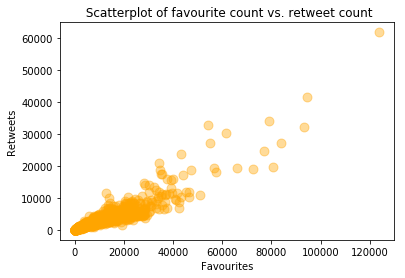

In [142]:
# Libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Create a scatterplot between favorite count and retweet count to see their behavioural nature
master_df.plot(kind='scatter', x="favorite_count", y="retweet_count",alpha=0.4, color='orange', s=80)
plt.xlabel('Favourites')
plt.ylabel('Retweets')
plt.title(' Scatterplot of favourite count vs. retweet count')



It is quite evident from the scatter plot that there exists a positive correlation between favorite and retweet counts.
As favorite count increaes, there is an increase in retweet counts as well.

### Most popular month to tweet

I would like to determine the most popular month to tweet by constructing barplots of months with tweet counts

In [143]:
# Converting date column to datetime
master_df['date']= pd.to_datetime(master_df['date'])


In [144]:
# Extracting month from date 
master_df['Month']=master_df.date.apply(lambda time: time.strftime('%m'))


In [145]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 22 columns):
tweet_id              1300 non-null object
source                1300 non-null object
name                  1300 non-null object
dog_stage             1300 non-null object
rating_numerator      1300 non-null float64
rating_denominator    1300 non-null float64
favorite_count        1300 non-null int64
retweet_count         1300 non-null int64
jpg_url               1300 non-null object
full_text             1300 non-null object
p1                    1300 non-null object
p1_conf               1300 non-null float64
p1_dog                1300 non-null bool
p2                    1300 non-null object
p2_conf               1300 non-null float64
p2_dog                1300 non-null bool
p3                    1300 non-null object
p3_conf               1300 non-null float64
p3_dog                1300 non-null bool
date                  1300 non-null datetime64[ns]
time                  1300 n

In [146]:
master_df.Month.value_counts()


12    273
11    245
01    145
02    108
07     99
03     96
06     81
04     68
05     63
09     43
10     40
08     39
Name: Month, dtype: int64

Text(0,0.5,'Months')

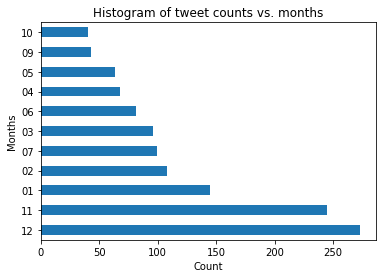

In [147]:
# Histogram of tweet counts vs months
master_df_month = master_df.groupby('Month').filter(lambda x: len(x) >= 40)
master_df_month['Month'].value_counts().plot(kind = 'barh')
plt.title('Histogram of tweet counts vs. months')
plt.xlabel('Count')
plt.ylabel('Months')

### Conclusion

Top three months when people tweet the most are December, November and January

### Most popular time to tweet

It would be interesting to identify when most people would tweet

In [148]:
# Converting time column to datetime
master_df['time']= pd.to_datetime(master_df['time'])

In [149]:
# Extracting hour from time column
master_df['Hour']=master_df.time.apply(lambda time: time.strftime('%H'))

Getting value counts before plotting

In [150]:
master_df.Hour.value_counts()

00    176
01    174
02    136
16    132
03    117
17     99
18     70
23     68
04     63
15     60
19     55
21     46
20     40
22     33
05     21
14      6
06      3
13      1
Name: Hour, dtype: int64

Text(0,0.5,'Time-Hours')

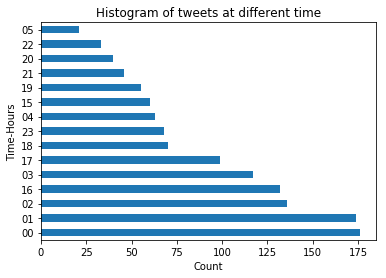

In [151]:
#Histogram of tweet counts at different time
master_df_time_hour = master_df.groupby('Hour').filter(lambda x: len(x) >= 20)
master_df_time_hour['Hour'].value_counts().plot(kind = 'barh')
plt.title('Histogram of tweets at different time')
plt.xlabel('Count')
plt.ylabel('Time-Hours')

### Conclusion

Top three times when most of the people tweet are at 12am, 1am and 2am.